In [444]:
import numpyro
numpyro.enable_x64()
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist

import jax
from jax import numpy as jnp
from jax import random
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS, Predictive, SA
from numpyro.contrib.funsor import config_enumerate

from jax.scipy.special import digamma, polygamma, logit, expit, erf, gammaln

import numpy as np
from numpy.random import default_rng
import pandas as pd
import siuba as s

from numpy import exp, log

import scipy

from plotnine import *
# import seaborn as sns

In [52]:
# from numerical recipes, licensing unclear
# http://www.it.uom.gr/teaching/linearalgebra/NumericalRecipiesInC/c6-4.pdf

from jax import grad, jit

# @jit # can't jit this but probabl doesn't matter?
def betaai_lax(a,b,x):
    # need to modify this to handle multidimensional inputs! maybe using vmap
    
    bt = jnp.where(
        jnp.logical_or(x==0, x==1),
        0.,
        jnp.exp(gammaln(a+b) - gammaln(a) - gammaln(b) + a*jnp.log(x) + b*jnp.log(1.-x))
    )
    
    res = jnp.where(
        x < (a+1.0)/(a+b+2.),
        bt*vec_betacf_lax(a,b,x)/a,
        1. - bt*vec_betacf_lax(b,a,1.-x)/b
    )
    
    divisor = jnp.where(jnp.logical_or(x <0.0, x > 1.0), 0., 1.) # create NAN if bad inputs
    
    return res/divisor

@jit
def lentz_method(m, carry):
    
    a = carry[0]
    b = carry[1]
    c = carry[2]
    d = carry[3]
    h = carry[4]
    x = carry[5]

    FPMIN = 1e-30
    
    qab = a+b
    qap = a + 1.
    qam = a-1. 
    
    
    numerator = m*(b-m)*x/((qam+m*2.) * (a+m*2.) )  
        
    # odd step
    d = 1. + numerator*d # depends on last step
    d = jnp.clip(d,FPMIN, jnp.inf)
    d = 1./d

    c = jnp.clip(c,FPMIN, jnp.inf)
    c = 1.0+numerator/c

    h = h*d*c

    # even step
    numerator = -(a+m) * (qab+m)*x/( (a+m*2.)*(qap+m*2.))

    d = 1. + numerator*d 
    d = jnp.clip(d,FPMIN, jnp.inf)
    d = 1./d

    c = jnp.clip(c,FPMIN, jnp.inf)
    c = 1.+numerator/c

    h = h*d*c
    
    return (a,b,c,d,h,x)

vec_lentz = jnp.vectorize(lentz_method)

@jit
def betacf_lax(a,b,x):

    FPMIN = 1e-30
    
    qab = a+b
    qap = a + 1.
    qam = a-1. 

    # initialize
    c = 1.0
    d = 1.0 - qab*x/qap
    d = jnp.clip(d,FPMIN, jnp.inf)
    d = 1./d
    h=d 

    res = jax.lax.fori_loop(1, 101, lentz_method, init_val = (a,b,c,d,h, x))
    
    return(res[4])
    
    
vec_betacf_lax = jnp.vectorize(betacf_lax)

betaai_lax(jnp.array([1,2]), jnp.array([2,3]), jnp.array([.5, .7]))


DeviceArray([0.7500001 , 0.91629994], dtype=float32)

In [53]:
# note need newer Jax to get autoddiff
# but still doesn't work in multidimensional case w/ grad itself
jax.grad(betaai_lax)(3., 3., .9)

DeviceArray(nan, dtype=float32, weak_type=True)

Looks like this is unlikely to work as the gradients calculated are very unstable, often returning nan

## Implementing the gradients with `custom_jvp`

The defjvps convenience wrapper lets us define a JVP for each argument separately, and the results are computed separately then summed:

```
@custom_jvp
def f(x, y):
  return x ** 2 * y

f.defjvps(lambda x_dot, primal_out, x, y: 2 * x * y * x_dot,
          lambda y_dot, primal_out, x, y: x ** 2 * y_dot)
```

In [54]:
from jax import custom_jvp
from jax.scipy.special import gammaln
from jax.numpy import log1p, log, exp


def logical_or_three(x1, x2, x3):
    return jnp.logical_or(jnp.logical_or(x1, x2), x3)

def logical_and_three(x1, x2, x3):
    return jnp.logical_and(jnp.logical_and(x1, x2), x3)


@custom_jvp
def _betainc(a,b,x):
    f = jax.scipy.special.betainc
    return f(a,b,x) # assign my own

# betainc = jax.vmap(_betainc,2)

def _betainc_dda_while(args):
    summand, sum_numer, sum_denom, a_plus_b, k, a_plus_1, digamma_ab, digamma_a, x = args
    
    sum_numer = sum_numer + (digamma_ab - digamma_a) * summand
    sum_denom += summand
    summand = summand*(1 + (a_plus_b) / k) * (1 + k) / (1 + a_plus_1 / k)
    digamma_ab += 1./(a_plus_b + k)
    digamma_a += 1./(a_plus_1 + k)
    k += 1
    summand = summand * (x / k)
    # summand = summand*1./10.
    args = (summand, sum_numer, sum_denom, a_plus_b, k, a_plus_1, digamma_ab, digamma_a, x) 
    
    return args


def betainc_dda(a_dot, primal_out, a, b, x):
    out = jnp.where(
        jnp.logical_or(
            jnp.logical_or(
                jnp.logical_or(
                    jnp.logical_and(x > .75, a < 500),
                    jnp.logical_and(x > .9, a < 2500)
                ),
                jnp.logical_or(
                    jnp.logical_and(x > .99, a < 1e5),
                    x > .999
                )
            ),
            jnp.logical_and(
            b > a,
            logical_or_three(
                logical_and_three(x > .1, x <= .75, b > 500),
                logical_and_three(x > .01, x <= .1, b > 2500),
                logical_and_three(x > .001, x <= .01, b > 1e5)   
            )
        )
        ),
        -1.*_betainc_ddb(a_dot, primal_out, b, a, 1 - x),
        _betainc_dda(a_dot, primal_out, b, a, 1.-x)
    )
    
    return out
        ## commented for now, need to implement as jax.lax.cond()
#     if b > a:
#         if ((0.1 < x and x <= 0.75 and b > 500) or (0.01 < x and x <= 0.1 and b > 2500) or (0.001 < x and x <= 0.01 and b > 1e5)):
#             return -_betainc_ddb(a_dot, primal_out, b, a, 1 - x)

#     elif (x > 0.75 and a < 500):
#         return -_betainc_ddb(a_dot, primal_out, b, a, 1 - x)
#     elif (x > 0.9 and a < 2500):
#         return -_betainc_ddb(a_dot, primal_out, b, a, 1 - x)
#     elif (x > 0.99 and a < 1e5):
#         return -_betainc_ddb(a_dot, primal_out, b, a, 1 - x)
#     elif (x > 0.999):
#         return -_betainc_ddb(a_dot, primal_out, b, a, 1 - x)



## define partial derivative wrt a
def _betainc_dda(a_dot, primal_out, a, b, x):
    # a = jnp.asarray(a)
    # b = jnp.asarray(a)
    # x = jnp.asarray(x)
    
    digamma_a = jax.scipy.special.digamma(a)
    digamma_ab = jax.scipy.special.digamma(a+b)
    

    
    threshold = 1e-10

    a_plus_b = a + b
    a_plus_1 = a + 1.
    
    digamma_a = digamma_a + 1./a
    
    prefactor = jnp.power(a_plus_1 / a_plus_b, 3)
    sum_numer = (digamma_ab - digamma_a) * prefactor
    sum_denom = prefactor
    summand = prefactor * x * a_plus_b / a_plus_1
    
    sum_numer = jnp.full_like(x, sum_numer)
    sum_denom = jnp.full_like(x, sum_denom)
    summand = jnp.full_like(x, summand)
    
    k = jnp.array(1)
    digamma_ab = digamma_ab + 1./a_plus_b
    digamma_a = digamma_a + 1./a_plus_1
    
    ### ----- 6/9/22, 4:03 PM something in the while loop changing the types?
    out = jax.lax.while_loop(
        lambda args: jnp.any( jnp.logical_and(jnp.abs(args[0]) > 1e-10, args[4] < 1e5) ),
        _betainc_dda_while,
        (summand, sum_numer, sum_denom, a_plus_b, k, a_plus_1, digamma_ab, digamma_a, x)
    )
    
    summand, sum_numer, sum_denom, a_plus_b, k, a_plus_1, digamma_ab, digamma_a, x = out
    
#     while jnp.any(jnp.abs(summand) > threshold): # transform this to jax.lax.while_loop() to vectorize ?
#         sum_numer += (digamma_ab - digamma_a) * summand
#         sum_denom += summand
#         summand = summand*(1 + (a_plus_b) / k) * (1 + k) / (1 + a_plus_1 / k)
#         digamma_ab += 1./(a_plus_b + k)
#         digamma_a += 1./(a_plus_1 + k)
#         k += 1
#         summand = summand * (x / k)
        
#         if k > 1e5:
#             return 1./0.
    
    
    return _betainc(a, b, x) * (log(x) + sum_numer / sum_denom)*a_dot


def _betainc_ddb_while(args):
    summand, sum_numer, sum_denom, a_plus_b, k, a_plus_1, digamma_ab, x = args
    
    sum_numer += digamma_ab * summand
    sum_denom += summand

    summand = summand*(1 + (a_plus_b) / k) * (1 + k) / (1 + a_plus_1 / k)
    digamma_ab += 1./(a_plus_b + k)
    k +=1
    summand = summand * x / k
    # summand = summand*1./10.
    args = (summand, sum_numer, sum_denom, a_plus_b, k, a_plus_1, digamma_ab, x)
    
    return args

    # jax.lax.cond(jnp.any(k > 1e5),lambda x: 1.0/0., lambda x: pass): # nothing to stop infinite loop for now
        

def betainc_ddb(b_dot, primal_out, a, b, x):
    out = jnp.where(
    jnp.logical_and(b > a, 
    logical_or_three(
        logical_and_three(
            x > .1, x <= .75, b > 500),
        logical_and_three(
            x > .01, x <= .1, b > 2500
        ),
        logical_and_three(
            x > .001, x <= .01, b > 1e5
        )
        )
    ),
    -1.*_betainc_dda(b_dot, primal_out, b, a, 1.-x),
    _betainc_ddb(b_dot, primal_out, a, b, x)
    )
        
    return out





## define partial derivative wrt b
def _betainc_ddb(b_dot, primal_out, a, b, x):
    
    digamma_b = jax.scipy.special.digamma(b)
    digamma_ab = jax.scipy.special.digamma(a+b)

    ## commented for now, need to implement as jax.lax.cond()
    


#     if (b > a):
#         if ((0.1 < x and x <= 0.75 and b > 500) or (0.01 < x and x <= 0.1 and b > 2500) or (0.001 < x and x <= 0.01 and b > 1e5)):
#             return -_betainc_dda(b_dot, primal_out, b, a, 1 - x);


#     if ((x > 0.75 and a < 500) or (x > 0.9 and a < 2500) or (x > 0.99 and a < 1e5) or (x > 0.999)):
#         return -_betainc_dda(b_dot, primal_out, b, a, 1 - x);
    
    threshold = 1e-10
    
    a_plus_b = a + b
    a_plus_1 = a + 1.
    
    prefactor = jnp.power(a_plus_1 / a_plus_b, 3)
    
    sum_numer = digamma_ab * prefactor
    sum_denom = prefactor
    summand = prefactor * x * a_plus_b / a_plus_1
    
    sum_numer = jnp.full_like(x, sum_numer)
    sum_denom = jnp.full_like(x, sum_denom)
    summand = jnp.full_like(x, summand)
    
    k = jnp.array(1)
    digamma_ab = digamma_ab + 1./a_plus_b
    
    out = jax.lax.while_loop(
        lambda args: jnp.any( jnp.logical_and(jnp.abs(args[0]) > 1e-10, args[4] < 1e5) ),
        _betainc_ddb_while,
        (summand, sum_numer, sum_denom, a_plus_b, k, a_plus_1, digamma_ab, x)
    )
    
    summand, sum_numer, sum_denom, a_plus_b, k, a_plus_1, digamma_ab, x = out
    
#     while jnp.any(jnp.abs(summand) > threshold): # transform this to jax.lax.while_loop() to vectorize ?
#         sum_numer += digamma_ab * summand
#         sum_denom += summand

#         summand = summand*(1 + (a_plus_b) / k) * (1 + k) / (1 + a_plus_1 / k)
#         digamma_ab += 1./(a_plus_b + k)
#         k +=1
#         summand = summand * x / k
        
#         if k > 1e5:
#             return 1./0.        
        
    
    return _betainc(a, b, x) * (log(1 - x) - digamma_b + sum_numer / sum_denom)*b_dot


def betainc_gradx(g, primal_out, a, b, x):
    lbeta = gammaln(a) + gammaln(b) - gammaln(a + b)
    partial_x = exp((b - 1) * log1p(-x) +
                  (a - 1) * log(x) - lbeta)
    return partial_x * g


_betainc.defjvps(betainc_dda, betainc_ddb, betainc_gradx)

# betainc_dda(jnp.array([1.,1.,1.]), None, jnp.array([3., 5, 1]), jnp.array([3., 5, 1]), jnp.array([.5,.6, .9]))

# # print(grad(_betainc)(2., 3., .5))
print(grad(_betainc, 0)(2., 1., .6))  # same as above
print(grad(_betainc, 1)(2., 1., .6))
print(grad(_betainc, 2)(2., 1., .6))

# _betainc.defjvps(None, None, betainc_gradx)
# print( grad(_betainc,2)(jnp.array([2.,3]), jnp.array([2.,3]), jnp.array([.5,.7])))

-0.34642628
0.34642622
1.1999998


In [55]:
# from jax.scipy.special import betainc, betaln, gammaln

# grad(_betainc, 0)(jnp.array([3., 5, 1]), jnp.array([3., 5, 1]), jnp.array([.5,.6, .9]))

_betainc(np.array([1,1]), np.array([1,3]), np.array([.25, .5]))

DeviceArray([0.24999976, 0.875     ], dtype=float32)

In [79]:
# !pip install betaincder

  Created wheel for betaincder: filename=betaincder-0.1.1-cp38-cp38-linux_x86_64.whl size=81494 sha256=74622bd42053b7c2c36ed92bb3078d87e2712db7b49d4c49003e345807ac1926
  Stored in directory: /home/jovyan/.cache/pip/wheels/a5/2d/eb/7ddc4f8ae93ba762e10d64dbc36768922dd77587a1fe7a56bd
Successfully built betaincder


In [118]:
from betaincder import betaincderp, betaincderq

vec_betaincderp = np.vectorize(betaincderp)
vec_betaincderq = np.vectorize(betaincderq)
# np.vectorize(betaincderp)(jnp.array([.5, .5]), jnp.array([10., 20.]), jnp.array([10.,10]))

@custom_jvp
def _betainc(a,b,x):
    f = jax.scipy.special.betainc
    return f(a,b,x) # assign my own

def betainc_grada(g, primal_out, a, b, x):
    return g*vec_betaincderp(x, a, b)

def betainc_gradb(g, primal_out, a, b, x):
    return g*vec_betaincderq(x, a, b)


def betainc_gradx(g, primal_out, a, b, x):
    lbeta = gammaln(a) + gammaln(b) - gammaln(a + b)
    partial_x = exp((b - 1) * log1p(-x) +
                  (a - 1) * log(x) - lbeta)
    return partial_x * g

_betainc.defjvps(betainc_grada, betainc_gradb, betainc_gradx)

In [119]:
# _betainc(np.array([1,1]), np.array([1,3]), np.array([.25, .5]))
print(grad(_betainc, 0)(2., 1., .6))  # same as above
print(grad(_betainc, 1)(2., 1., .6))
print(grad(_betainc, 2)(2., 1., .6))

-0.18389723
0.34642607
1.1999998


array([-0.09109296, -0.01093529])

# Testing on some rounded data

In [2]:
from jax.random import PRNGKey

X_raw = dist.Beta(.75*10, (1-.75)*10).sample(PRNGKey(10), (100,))
x_round = round(X_raw*10)
x_round

DeviceArray([ 7,  9,  9,  8,  6,  7,  8,  9,  9,  8,  7,  6,  8,  9,  7,
              8,  8,  8,  8,  9,  6, 10,  6,  9,  5,  8,  9, 10,  7,  8,
              9,  7,  7,  8,  6,  6,  8,  8,  5,  8,  7,  4,  9,  9,  9,
              7,  9,  9,  8,  8,  6,  6,  8,  5,  6,  8,  9,  8,  4,  8,
              7,  6,  4,  7,  8,  7,  7,  7,  8,  8,  6,  9,  9,  8,  7,
              5,  9,  9,  6,  9,  9,  7,  8,  5,  5,  7,  9,  6,  7,  8,
              8,  9,  8,  5,  8,  7,  8,  7,  7,  7], dtype=int32)

In [86]:
def mymodel(x=None):
    mu = numpyro.sample("mu", dist.Beta(1,1)) # noise parameter
    k = numpyro.sample("k", dist.HalfCauchy(10)) # noise parameter
    
    with numpyro.plate("data", x.shape[0]):
        xhat = numpyro.sample("xhat", dist.Beta(mu*k, (1-mu)*k), obs=x)

In [87]:
kernel = NUTS(mymodel, target_accept_prob=.80)

mcmc = MCMC(kernel, 
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=1)

mcmc.run(random.PRNGKey(0), X_raw)

sample: 100%|██████████| 4000/4000 [00:03<00:00, 1075.68it/s, 3 steps of size 8.10e-01. acc. prob=0.92]


In [88]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         k      8.81      1.19      8.77      6.87     10.73   1224.80      1.00
        mu      0.75      0.01      0.75      0.72      0.77   1217.59      1.00

Number of divergences: 0


In [60]:
# def betacdf(alpha, beta, x):
#     vals = jnp.arange(1000+1)
#     probs = jnp.exp(dist.BetaBinomial(alpha, beta, 1000).log_prob(vals))
#     # then sum up probs below x 
#     validprobs = jnp.where(vals < x*1000, probs, 0.)
    
#     return jnp.sum(validprobs)

# betacdf = jnp.vectorize(betacdf)

# betacdf(3, 3, .5)

# def betacdf(alpha, beta, x):
#     vals = jnp.linspace(1e-5, 1.-1e-5, num=10000)
#     probs = jnp.exp(dist.Beta(alpha, beta).log_prob(vals))
#     # then sum up probs below x 
#     validprobs = jnp.where(vals <= x, probs, 0.)
    
#     return jnp.sum(validprobs/10000.)

# betacdf = jnp.vectorize(betacdf)

# betacdf(1., 1., .500)

# this very naive approximation seems to work? but how/why when it didn't seem to work before?

In [271]:
import tensorflow_probability.substrates.jax as tfp

def f(mu, k):
    a = mu*k
    b = (1.-mu)*k
    
    responses = jnp.linspace(0,10, num=11)
    lower = jnp.clip((responses/10.) - .05, 1e-3, 1-1e-3)
    upper = jnp.clip((responses/10.) + .05, 1e-3, 1-1e-3)
    
    prob_resps = tfp.math.betainc(a, b, upper) - tfp.math.betainc(a, b, lower)
    prob_resps = prob_resps / jnp.sum(prob_resps)
    
    return(prob_resps)


def mymodel_round(x=None):
    mu = numpyro.sample("mu", dist.Beta(1,1)) # noise parameter
    k = numpyro.sample("k", dist.HalfCauchy(10)) # noise parameter

    resp_probs = f(mu,k)
    resp_probs = resp_probs/jnp.sum(resp_probs)
    
    with numpyro.plate("data", x.shape[0]):

        xhat = numpyro.sample("xhat", dist.Categorical(probs=resp_probs), obs=x)


In [260]:
from numpyro.infer import init_to_median, init_to_value

kernel = NUTS(mymodel_round, target_accept_prob=.80, init_strategy = init_to_value(values={"mu":.33, "k":5}))

mcmc = MCMC(kernel, 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=1)

mcmc.run(random.PRNGKey(0), x_round)

sample: 100%|██████████| 2000/2000 [00:08<00:00, 243.85it/s, 3 steps of size 8.52e-01. acc. prob=0.91] 


In [261]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         k      9.69      1.43      9.69      7.50     12.03    785.03      1.00
        mu      0.75      0.01      0.75      0.73      0.77    776.91      1.00

Number of divergences: 0


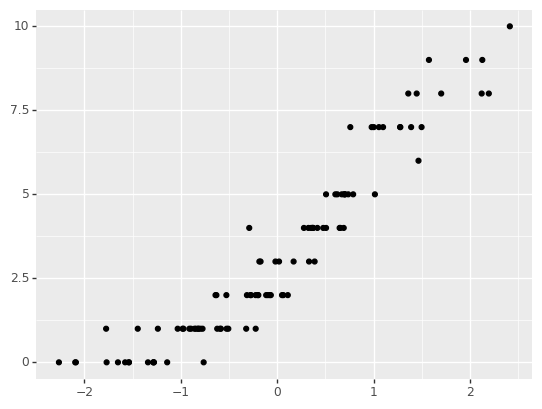

<ggplot: (8791051983758)>

In [452]:
x_norm = dist.Normal(0.,1.).sample(PRNGKey(1), (100,))
y = expit(-1 + 1.5*x_norm)
y = dist.Beta(y*50., (1-y)*50.).sample(PRNGKey(1))

y_round_10 = round(y*10)
y_round_5 = round(y*20)


# x_binary = dist.Bernoulli(.5).sample(PRNGKey(1), (100,))
# y = .25 + x_binary*.50
# y = dist.Beta(y*50., (1-y)*50.).sample(PRNGKey(0))

# y_round_bin10 = round(y*10)
# y_round

ggplot(aes(x=x_norm, y=y_round_10)) + geom_point()

In [272]:
# from jax import vmap
# vmap(f,(0,0))(jnp.array([.11, .21, .3]), jnp.array([10, 20, 30]))

In [501]:
def f2(mu, k):
    a = mu*k
    b = (1.-mu)*k
    
    rnd_unit_scaled = 1/10.
    
#     responses = jnp.linspace(1, 9, num=9)
#     cuts = responses/10.

#     upper_probs = jnp.pad(tfp.math.betainc(a, b, cuts+.05), (0,1), constant_values=(0.,1.))
#     lower_probs = jnp.pad(tfp.math.betainc(a, b, cuts-.05), (1,0), constant_values=(0.,1.))

    responses = jnp.linspace(0, 10, num=11)
    cuts = responses/10.

    upper_probs = jnp.pad(tfp.math.betainc(a, b, cuts[0:10]+.05), (0,1), constant_values=(0.,1.))
    lower_probs = jnp.pad(tfp.math.betainc(a, b, cuts[1:11]-.05), (1,0), constant_values=(0.,1.))

    prob_resps = upper_probs - lower_probs
    prob_resps = (prob_resps + 1e-16) / jnp.sum(prob_resps)
    
    return(prob_resps)


responses_10 = jnp.linspace(0, 10, num=11)
responses_5 = jnp.linspace(0, 20, num=21)
responses_1 = jnp.linspace(0, 101, num=101)

# def f2(mu, k, responses):
#     a = mu*k
#     b = (1.-mu)*k
#     n_resps = (responses.shape[0]-1)
#     rnd_unit_scaled = 1/n_resps
    
#     # responses = jnp.linspace(0, 10, num=11)
#     lower = jnp.clip((responses/n_resps) - rnd_unit_scaled/2., 1e-3, 1-1e-3)
#     upper = jnp.clip((responses/n_resps) + rnd_unit_scaled/2., 1e-3, 1-1e-3)
    
#     prob_resps = tfp.math.betainc(a, b, upper) - tfp.math.betainc(a, b, lower)
#     prob_resps = (prob_resps + 1e-16) / jnp.sum(prob_resps) # add err to prevent divergences
    
#     return(prob_resps)


f2_multi = vmap(f2, (0, None))

def mymodel_round2(x, y=None):
    
    alpha = numpyro.sample("alpha", dist.Normal(0,1))
    beta = numpyro.sample("beta", dist.Normal(0,1))
    k = numpyro.sample("k", dist.HalfCauchy(10)) # noise parameter
    
    mu = expit(alpha + beta*x)

    resp_probs = f2_multi(mu,k)
    
    with numpyro.plate("data", x.shape[0]):

        yhat = numpyro.sample("yhat", dist.Categorical(probs=resp_probs), obs=y) # rounded

In [ ]:
kernel2 = NUTS(
    mymodel_round2, 
    target_accept_prob=.80#,
    # init_strategy = init_to_value(values = {"alpha":0., "beta":0., "k":5.})
)

mcmc2 = MCMC(kernel2, 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=1)

mcmc2.run(random.PRNGKey(0), x_norm, y_round_10)

sample:  71%|███████   | 1423/2000 [01:30<00:36, 15.93it/s, 3 steps of size 7.03e-01. acc. prob=0.92] 

In [503]:
mcmc2.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     -1.04      0.04     -1.04     -1.11     -0.97    799.47      1.00
      beta      1.49      0.05      1.48      1.40      1.58    858.86      1.00
         k     50.11      9.74     48.75     34.80     65.23    847.19      1.00

Number of divergences: 0


## it works!????

seems to work with the betabinomial approximation above!??!?!?

In [76]:
x = jnp.array([.5,.5])
a, b = jnp.array([1.,2.]), jnp.array([1.,3.])
# x = jnp.array([.5])
# a, b = 1., 1.

digamma_a = jax.scipy.special.digamma(a)
digamma_ab = jax.scipy.special.digamma(a+b)

a_plus_b = a + b
a_plus_1 = a + 1

digamma_a = digamma_a + 1./a

prefactor = jnp.power(a_plus_1 / a_plus_b, 3)
sum_numer = (digamma_ab - digamma_a) * prefactor
sum_denom = prefactor
summand = prefactor * x * a_plus_b / a_plus_1

k = 1
digamma_ab = digamma_ab + 1./a_plus_b
digamma_a = digamma_a + 1./a_plus_1

inits = (summand, sum_numer, sum_denom, a_plus_b, k, a_plus_1, digamma_ab, digamma_a, x)

inits
# _betainc_dda_while(inits)

# out = jax.lax.while_loop(
#         lambda args: jnp.any(jnp.abs(args[0]) > 1e-10),
#         _betainc_dda_while,
#         inits
#     )

# out

(DeviceArray([0.5       , 0.18000002], dtype=float32),
 DeviceArray([0.        , 0.12600006], dtype=float32),
 DeviceArray([1.        , 0.21600002], dtype=float32),
 DeviceArray([2., 5.], dtype=float32),
 1,
 DeviceArray([2., 3.], dtype=float32),
 DeviceArray([0.9227846, 1.7061182], dtype=float32),
 DeviceArray([0.9227846, 1.2561179], dtype=float32),
 DeviceArray([0.5, 0.5], dtype=float32))

In [77]:
## define partial derivative wrt a
def _betainc_dda2(a_dot, primal_out, a, b, x):
    # a = jnp.asarray(a)
    # b = jnp.asarray(a)
    # x = jnp.asarray(x)
    
    digamma_a = jax.scipy.special.digamma(a)
    digamma_ab = jax.scipy.special.digamma(a+b)
    
    ## commented for now, need to implement as jax.lax.cond()
#     if b > a:
#         if ((0.1 < x and x <= 0.75 and b > 500) or (0.01 < x and x <= 0.1 and b > 2500) or (0.001 < x and x <= 0.01 and b > 1e5)):
#             return -_betainc_ddb(a_dot, primal_out, b, a, 1 - x)

#     elif (x > 0.75 and a < 500):
#         return -_betainc_ddb(a_dot, primal_out, b, a, 1 - x)
#     elif (x > 0.9 and a < 2500):
#         return -_betainc_ddb(a_dot, primal_out, b, a, 1 - x)
#     elif (x > 0.99 and a < 1e5):
#         return -_betainc_ddb(a_dot, primal_out, b, a, 1 - x)
#     elif (x > 0.999):
#         return -_betainc_ddb(a_dot, primal_out, b, a, 1 - x)
    
    threshold = 1e-10

    a_plus_b = a + b
    a_plus_1 = a + 1.
    
    digamma_a = digamma_a + 1./a
    
    prefactor = jnp.power(a_plus_1 / a_plus_b, 3)
    sum_numer = (digamma_ab - digamma_a) * prefactor
    sum_denom = prefactor
    summand = prefactor * x * a_plus_b / a_plus_1
    
    k = jnp.array(1)
    digamma_ab = digamma_ab + 1./a_plus_b
    digamma_a = digamma_a + 1./a_plus_1
    
    inits = (summand, sum_numer, sum_denom, a_plus_b, k, a_plus_1, digamma_ab, digamma_a, x)
    ### ----- 6/9/22, 4:03 PM something in the while loop changing the types?
    out = jax.lax.while_loop(
        lambda args: jnp.any(jnp.abs(args[0]) > 1e-10),
        _betainc_dda_while,
        inits
    )
    
    summand, sum_numer, sum_denom, a_plus_b, k, a_plus_1, digamma_ab, digamma_a, x = out
    
#     while jnp.any(jnp.abs(summand) > threshold): # transform this to jax.lax.while_loop() to vectorize ?
#         sum_numer += (digamma_ab - digamma_a) * summand
#         sum_denom += summand
#         summand = summand*(1 + (a_plus_b) / k) * (1 + k) / (1 + a_plus_1 / k)
#         digamma_ab += 1./(a_plus_b + k)
#         digamma_a += 1./(a_plus_1 + k)
#         k += 1
#         summand = summand * (x / k)
        
#         if k > 1e5:
#             return 1./0.
    
    
    return (inits, out)


z, w = _betainc_dda2(jnp.array([1.,1.]), None, jnp.array([1.,3.]), jnp.array([1.,3.]), jnp.array([.1,.3]))
print(z[3].shape)
print(w[3].shape)

(2,)
(2,)


In [78]:
z, w = _betainc_dda2(jnp.array(1.), None, jnp.array(2.), jnp.array(2.), jnp.array(.3))
w

(DeviceArray(3.5303732e-11, dtype=float32, weak_type=True),
 DeviceArray(0.20089278, dtype=float32, weak_type=True),
 DeviceArray(0.68877554, dtype=float32, weak_type=True),
 DeviceArray(4., dtype=float32, weak_type=True),
 DeviceArray(21, dtype=int32, weak_type=True),
 DeviceArray(3., dtype=float32, weak_type=True),
 DeviceArray(3.1987426, dtype=float32, weak_type=True),
 DeviceArray(3.157076, dtype=float32, weak_type=True),
 DeviceArray(0.3, dtype=float32, weak_type=True))

In [323]:
z+=1
z

DeviceArray([6], dtype=int32)